In [420]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from scipy.optimize import minimize

#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.linear_model import LinearRegression
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf
from pandas.tseries.frequencies import to_offset

from contextualized.easy import ContextualizedRegressor
import plotly.graph_objects as go

In [421]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

def difference(series, order=1):
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    return last_original + differenced

def create_lag_features(series, p_lags, q_lags):
    X_ar = pd.DataFrame(index=series.index)
    for lag in p_lags:
        X_ar[f'lag_{lag}'] = series.shift(lag)
    
    X_ma = pd.DataFrame(index=series.index)
    for lag in q_lags:
        X_ma[f'ma_{lag}'] = 0
    
    if len(q_lags) > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar

    X = X.dropna()
    y = series.loc[X.index]
    return X, y
    


In [422]:
from sklearn.linear_model import Ridge

def ARIMA(p, i, q, s, alpha=1.0):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Uses Ridge Regression with specified regularization strength alpha.
    """
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    original_series = s.copy()
    differenced_series = difference(s, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_
        residuals = y - regression_model.predict(X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = Ridge(alpha=alpha)
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]

        # Final fit with AR + MA features
        regression_model = Ridge(alpha=alpha)
        regression_model.fit(X, y)
        coef = regression_model.coef_
        intercept = regression_model.intercept_

        preds = regression_model.predict(X)
        print(preds.shape)
        residuals = y - preds

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coef': coef,
        'intercept': intercept,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X,
        'y_train': y,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict


In [423]:
def ContextualisedARIMA(p, i, q, s, C, n_bootstraps=1, alpha=0.1):
    """
    Fit an ARIMA model with specified AR (p), differencing (i), and MA (q) lags.
    Includes an intercept and uses standard Linear Regression directly.
    """
    if not isinstance(s, pd.Series):
        s = pd.Series(s)

    original_series = s.copy()
    differenced_series = difference(s, order=i)
    X, y = create_lag_features(differenced_series, p, q)

    if len(q) == 0:
        # No MA terms: fit immediately
        regression_model = ContextualizedRegressor(n_bootstraps=n_bootstraps, alpha=alpha)
        regression_model.fit(C, X, y,
            encoder_type="mlp",
            max_epochs=10,
          learning_rate=1e-2)
        coefs, intercepts = regression_model.predict_params(C)
        residuals = y - regression_model.predict(C, X)
    else:
        # First fit AR part only to get residuals
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        ar_X = X[ar_cols]

        ar_model = Ridge(alpha=1)
        ar_model.fit(ar_X, y)
        ar_coef = ar_model.coef_
        intercept = ar_model.intercept_

        residuals = y - ar_model.predict(ar_X)

        # Create true MA features from residuals
        for lag in q:
            X[f'ma_{lag}'] = residuals.shift(lag)

        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]
        X_cols = X.columns

        C = C.loc[X.index].to_numpy()
        X_df = X
        X = X.to_numpy()
        y = y.to_numpy()

        # Final fit with AR + MA features
        regression_model = ContextualizedRegressor(n_bootstraps=n_bootstraps, alpha=alpha)
        regression_model.fit(C, X, y,
            encoder_type="mlp",
            max_epochs=10,
          learning_rate=1e-2)
        coefs, intercepts = regression_model.predict_params(C)
        preds = regression_model.predict(C, X).flatten()
        print(preds.shape)
        residuals = y - preds
        residuals = pd.Series(residuals, index=X_df.index)

    sigma2 = np.var(residuals)
    n = len(residuals)
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - (0.5 / sigma2) * np.sum(residuals**2)

    max_p = max(p) if len(p) > 0 else 0
    max_q = max(q) if len(q) > 0 else 0
    max_lag = max(max_p, max_q)

    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'coefs': coefs,
        'intercepts': intercepts,
        'model': regression_model,
        'sigma2': sigma2,
        'log_likelihood': log_likelihood,
        'X_cols': X_cols,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'X_train': X_df,
        'y_train': y,
        'C_train': C,
        'last_values': original_series.iloc[-max_lag:].values if max_lag > 0 else original_series.iloc[-1:].values,
        'last_diff_values': differenced_series.iloc[-max_lag:].values if max_lag > 0 and len(differenced_series) >= max_lag else differenced_series.values,
    }
    return model_dict

In [424]:
def forecast(model_dict, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)
        
        # Predict the differenced value
        diff_forecast = model.predict(X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta(f)
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [425]:
def rolling_forecast(model_dict, true_series):
    """
    Perform a rolling forecast: predict one step ahead, then observe true value and update history.
    """
    from pandas.tseries.frequencies import to_offset

    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series'].copy()
    differenced_series = model_dict['differenced_series'].copy()
    residuals = model_dict['residuals'].copy()
    print(residuals)

    start_idx = original_series.index[-1]
    true_series = true_series[true_series.index > start_idx]

    forecasts = []

    for t_idx in true_series.index:
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(differenced_series) - lag >= 0:
                ar_features.append(differenced_series.iloc[-lag])
            else:
                ar_features.append(np.nan)

        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(residuals) - lag >= 0:
                ma_features.append(residuals.iloc[-lag])
            else:
                ma_features.append(0.0)

        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)

        diff_forecast = model.predict(X_pred)[0]
        print(type(diff_forecast))

        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")

        last_original_value = original_series.iloc[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)

        # Update history:
        if t_idx in true_series.index:
            true_value = true_series.loc[t_idx]
        else:
            true_value = inv_forecast

        # Update series with the "observed" value
        original_series = pd.concat([original_series, pd.Series([true_value], index=[t_idx])])
        new_diff = true_value - last_original_value
        differenced_series = pd.concat([differenced_series, pd.Series([new_diff], index=[t_idx])])

        resid = true_value - inv_forecast
        residuals = pd.concat([residuals, pd.Series([resid], index=[t_idx])])

    return forecasts


In [502]:
def c_forecast(model_dict, C, steps=1):
    """
    Forecast future values based on the fitted ARIMA model with selected lags.
    This function produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']  # p is a list of AR lags
    i = model_dict['i']
    q_lags = model_dict['q']  # q is a list of MA lags
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    
    # We keep track of recent differenced values and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                # For future predictions, we assume residuals are 0 if not available
                ma_features.append(0.0)
        
        # Combine AR and MA features in the same order as training
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)

        C_pred = C.loc[[_]].to_numpy()
        
        # Predict the differenced value
        diff_forecast = model.predict(C, X_pred)[0]
        
        # Update the differenced series and residuals
        # Generate a new index for the forecast step
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            # If it's a time index, step by frequency
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [509]:
def c_forecast(model_dict, C, steps=1):
    """
    Forecast future values using a contextualised ARIMA model.
    Produces forecasts one-step ahead, iteratively.
    """
    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    differenced_series = model_dict['differenced_series']
    
    forecasts = []
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    # Assume C is indexed by date and aligned with future steps
    future_context = C.iloc[:steps].copy()  # Get the required context rows
    
    for step in range(steps):
        # Build AR features
        ar_features = [current_diff.iloc[-lag] if len(current_diff) >= lag else np.nan for lag in p_lags]
        
        # Build MA features
        ma_features = [current_resid.iloc[-lag] if len(current_resid) >= lag else 0.0 for lag in q_lags]
        
        # Build input for the model
        X_pred = pd.DataFrame([ar_features + ma_features], columns=X_cols).astype(float).to_numpy()
        C_pred = future_context.iloc[[step]].to_numpy()
        
        # Make prediction
        diff_forecast = model.predict(C_pred, X_pred)[0]
        
        # Extend differenced and residuals series
        if isinstance(current_diff.index[-1], (int, float)):
            new_index = current_diff.index[-1] + 1
        else:
            new_index = current_diff.index[-1] + pd.Timedelta('1D')
        
        current_diff.loc[new_index] = diff_forecast
        current_resid.loc[new_index] = 0.0  # Assumes 0 residuals for future
        
        # Invert differencing (only 1st order supported)
        last_original_value = original_series.iloc[-1] if not forecasts else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [426]:
def c_rolling_forecast(model_dict, true_series, C):
    """
    Perform a rolling forecast: predict one step ahead, then observe true value and update history.
    """
    from pandas.tseries.frequencies import to_offset

    p_lags = model_dict['p']
    i = model_dict['i']
    q_lags = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series'].copy()
    differenced_series = model_dict['differenced_series'].copy()
    residuals = model_dict['residuals'].copy()

    start_idx = original_series.index[-1]
    true_series = true_series[true_series.index > start_idx]

    forecasts = []

    for t_idx in true_series.index:
        # Build AR features
        ar_features = []
        for lag in p_lags:
            if len(differenced_series) - lag >= 0:
                ar_features.append(differenced_series.iloc[-lag])
            else:
                ar_features.append(np.nan)

        # Build MA features
        ma_features = []
        for lag in q_lags:
            if len(residuals) - lag >= 0:
                ma_features.append(residuals.iloc[-lag])
            else:
                ma_features.append(0.0)

        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols).to_numpy() 

        # get Contextual features
        C_pred = C.loc[[t_idx]].to_numpy() 
        #print(X_pred)
        #print(C_pred)

        diff_forecast = model.predict(C_pred,X_pred).item()

        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")

        last_original_value = original_series.iloc[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)

        # Update history:
        if t_idx in true_series.index:
            true_value = true_series.loc[t_idx]
        else:
            true_value = inv_forecast

        # Update series with the "observed" value
        original_series = pd.concat([original_series, pd.Series([true_value], index=[t_idx])])
        new_diff = true_value - last_original_value
        differenced_series = pd.concat([differenced_series, pd.Series([new_diff], index=[t_idx])])

        resid = true_value - inv_forecast
        residuals = pd.concat([residuals, pd.Series([resid], index=[t_idx])])

    return forecasts


In [427]:
def get_significant_acf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    acf_vals, confint = acf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(acf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

def get_significant_pacf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    pacf_vals, confint = pacf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

In [428]:
# read daily close price data
file_path1 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
file_path2 = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_Compustat_quarterly_ratiodata_alltime.csv' # Fundamental ratios (Compustat)

df1 = pd.read_csv(file_path1)
df2 = pd.read_csv(file_path2)

# Ensure that the date column is in datetime format
df1['date'] = pd.to_datetime(df1['date'], errors='coerce')
df2['qdate'] = pd.to_datetime(df2['qdate'])  # Financial ratios data
# Sort by qdate and public_date to ensure the most recent public_date comes last
df2_sorted = df2.sort_values(by=['qdate', 'public_date'])
# Drop duplicates to keep only the latest public_date for each qdate
df2_latest = df2_sorted.drop_duplicates(subset='qdate', keep='last')
# Make a copy to avoid modifying the original df3_latest
df2_latest_pct = df2_latest.copy()
# Select columns to calculate percentage change, excluding identifier and date columns
columns_to_change = ['npm', 'de_ratio', 'curr_ratio', 'ptb'] # Apply pct_change to each selected column and multiply by 100 to express as percentage
df2_latest_pct[columns_to_change] = df2_latest[columns_to_change].pct_change()

df = pd.merge_asof(
    df1,  # Daily data sorted by date
    df2_latest_pct,  # Fundamental data sorted by quarterly date
    left_on='date', right_on='qdate',  # Merge on dates
    direction='backward'  # Merge to the closest past quarter
)

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Convert df to a Pandas Series using the 'PRC' column
f = 'W-SUN' # 'W-SUN' means week ending on Sunday
df = df.resample(f).last()
df = df.dropna()

start_date = '2017-1-30'
end_train_date = '2018-9-30'
end_date = '2025-12-24'

# Filter the data according to the date range
df = df[(df.index >= start_date) & (df.index <= end_date)]
df_train = df[(df.index >= start_date) & (df.index <= end_train_date)]
df_test = df[(df.index > df_train.index[-1]) & (df.index < end_date)]

df_test.tail()

,PERMNO,TICKER_x,BIDLO,ASKHI,PRC,VOL,RET,OPENPRC,permno,adate,qdate,public_date,npm,de_ratio,curr_ratio,ptb,TICKER_y
date,,,,,,,,,,,,,,,,,
2023-12-03,11850.0,XOM,102.22,104.2200,102.99,17845276.0,0.002433,102.50,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-10,11850.0,XOM,98.75,99.7867,99.55,22074945.0,0.011481,99.02,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-17,11850.0,XOM,100.31,101.0000,100.90,55527018.0,-0.006694,100.59,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-24,11850.0,XOM,101.82,102.9400,101.91,12927831.0,0.001769,102.31,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM
2023-12-31,11850.0,XOM,99.62,100.5900,99.98,17746408.0,-0.002096,100.37,11850.0,2022-12-31,2023-09-30,2023-12-31,-0.161972,-0.035253,0.015482,-0.049867,XOM


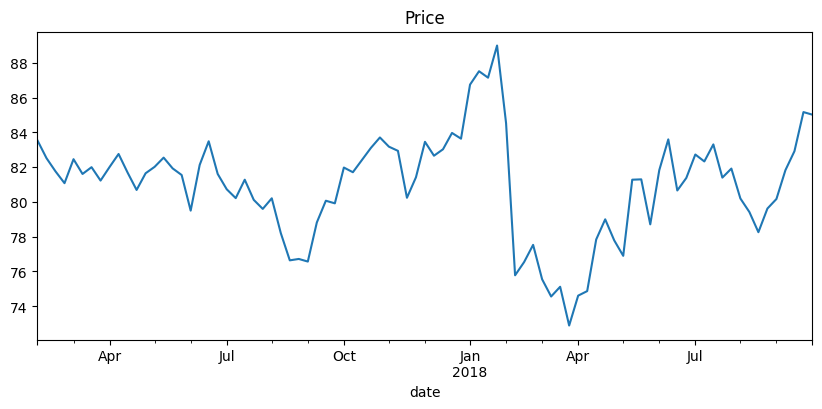

In [429]:
s = df['PRC']
s_train = df_train['PRC']
s_test = df_test['PRC']

C_df = df[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
C_train = df_train[['npm', 'de_ratio', 'curr_ratio', 'ptb']]
C_test = df_test[['npm', 'de_ratio', 'curr_ratio', 'ptb']]

# Plot the series
s_train.plot(title='Price', figsize=(10, 4))
plt.show()


In [430]:
s_train.describe()
s_train.head()

date
2017-02-05    83.54
2017-02-12    82.52
2017-02-19    81.76
2017-02-26    81.08
2017-03-05    82.46
Freq: W-SUN, Name: PRC, dtype: float64

In [431]:
C_test.head()

,npm,de_ratio,curr_ratio,ptb
date,,,,
2018-10-07,0.05,-0.015532,-0.00489,-0.094543
2018-10-14,0.05,-0.015532,-0.00489,-0.094543
2018-10-21,0.05,-0.015532,-0.00489,-0.094543
2018-10-28,0.05,-0.015532,-0.00489,-0.094543
2018-11-04,0.05,-0.015532,-0.00489,-0.094543


In [432]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(s_train)
# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [433]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(s)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


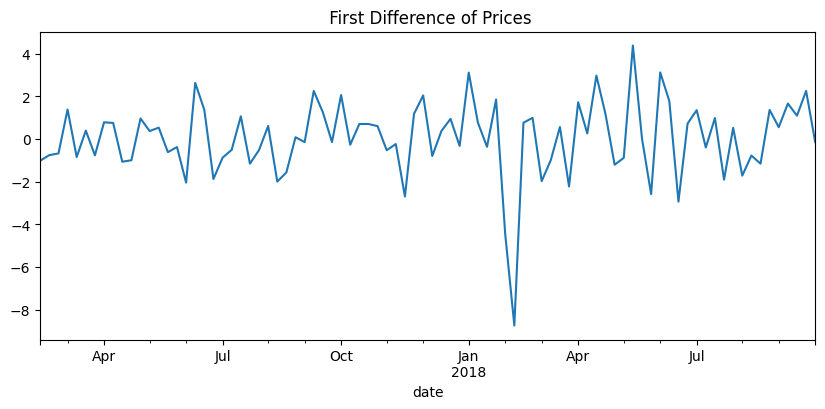

In [434]:
s_train_diffed = difference(s_train)

s_train_diffed.plot(title=' First Difference of Prices', figsize=(10, 4))
plt.show()

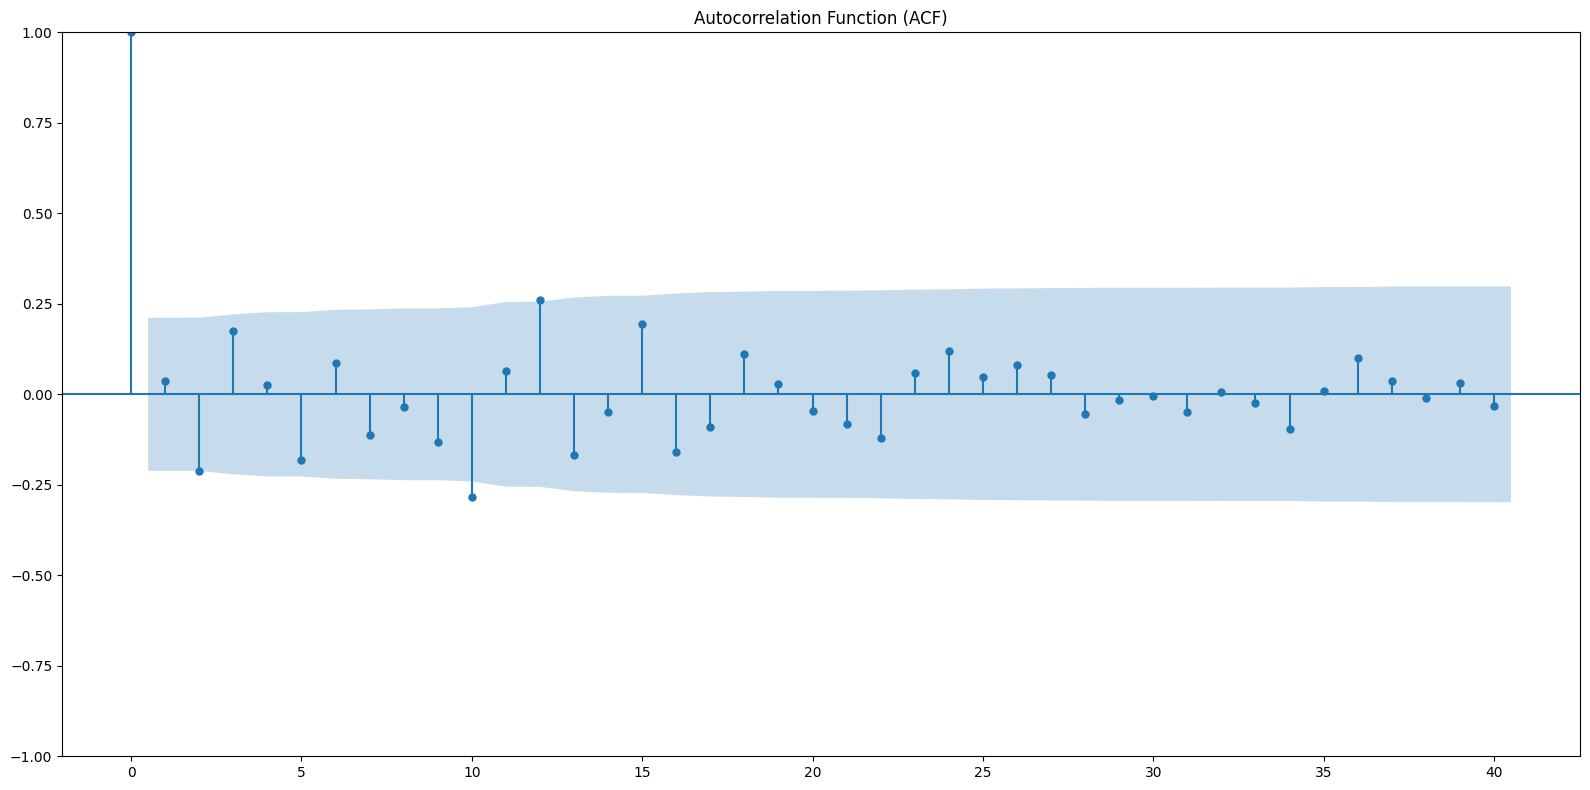

Significant ACF lags:
[2, 10, 12]


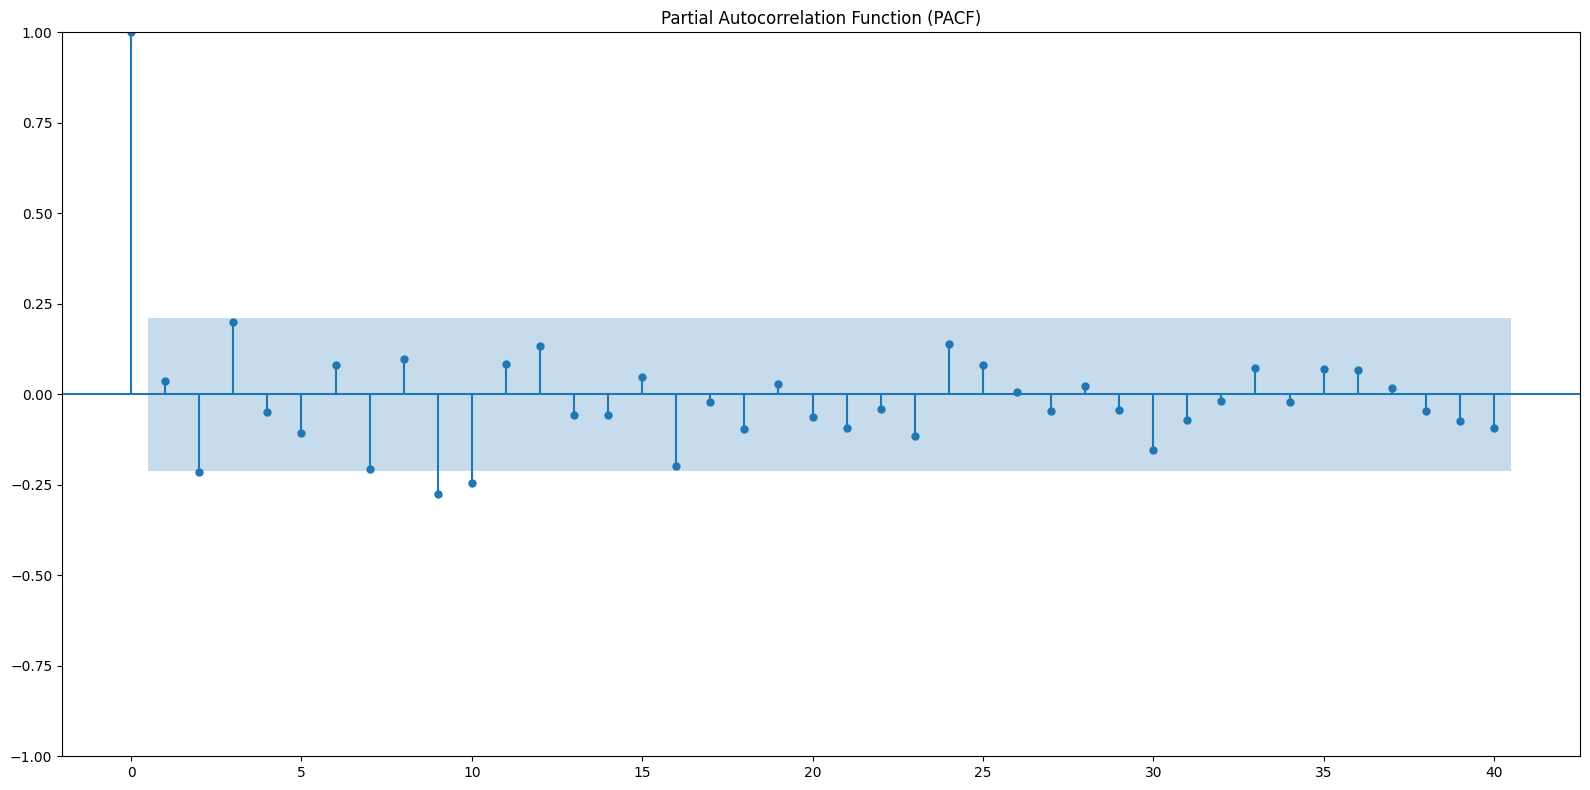

Significant PACF lags:
[2, 7, 9, 10, 16, 24, 30, 39, 40]


In [435]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(s_train_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(s_train_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(s_train_diffed)

print("Significant PACF lags:")
print(p)

In [436]:
print(C_train.shape)
C_train

(87, 4)


,npm,de_ratio,curr_ratio,ptb
date,,,,
2017-02-05,-0.111111,-0.018888,0.010465,0.015357
2017-02-12,-0.111111,-0.018888,0.010465,0.015357
2017-02-19,-0.111111,-0.018888,0.010465,0.015357
2017-02-26,-0.111111,-0.018888,0.010465,0.015357
2017-03-05,-0.111111,-0.018888,0.010465,0.015357
...,...,...,...,...
2018-09-02,-0.036145,-0.012972,-0.006075,-0.018680
2018-09-09,-0.036145,-0.012972,-0.006075,-0.018680
2018-09-16,-0.036145,-0.012972,-0.006075,-0.018680


In [437]:
#p = [2, 3, 4, 5, 6, 7, 8, 9, 10, 16, 24, 30]

p = list(range(1,30))
q = list(range(1,10))

# Fit the ARIMA model
model_dict = ARIMA(p=p, i=1, q=q, s=s_train, alpha=10)  # ARIMA returns a model_dict

# Access and print the learned parameters
coef = model_dict['coef']  # Coefficients of the AR and MA terms
intercept = model_dict['intercept']  # Intercept of the linear model
X_cols = model_dict['X_cols']  # Column names of the features (lags)

# Display the parameters
print("Learned Parameters:")
print(f"Intercept: {intercept:.4f}")
print("Coefficients:")
for col, weight in zip(X_cols, coef):
    print(f"{col}: {weight:.4f}")


(48,)
Learned Parameters:
Intercept: -0.0461
Coefficients:
lag_1: 0.2012
lag_2: -0.0720
lag_3: 0.2632
lag_4: 0.1078
lag_5: -0.2248
lag_6: -0.0104
lag_7: -0.1474
lag_8: 0.1012
lag_9: 0.0110
lag_10: -0.2769
lag_11: 0.1080
lag_12: 0.1727
lag_13: -0.1540
lag_14: -0.0017
lag_15: 0.0429
lag_16: -0.1316
lag_17: 0.0583
lag_18: -0.0765
lag_19: 0.0621
lag_20: -0.1510
lag_21: -0.0402
lag_22: -0.0909
lag_23: -0.0595
lag_24: 0.1185
lag_25: 0.1726
lag_26: -0.0499
lag_27: -0.1304
lag_28: -0.0146
lag_29: -0.0699
ma_1: -0.0160
ma_2: -0.1910
ma_3: -0.0889
ma_4: -0.1274
ma_5: -0.1443
ma_6: 0.2348
ma_7: -0.1568
ma_8: -0.0690
ma_9: -0.3294


<class 'pandas.core.series.Series'>


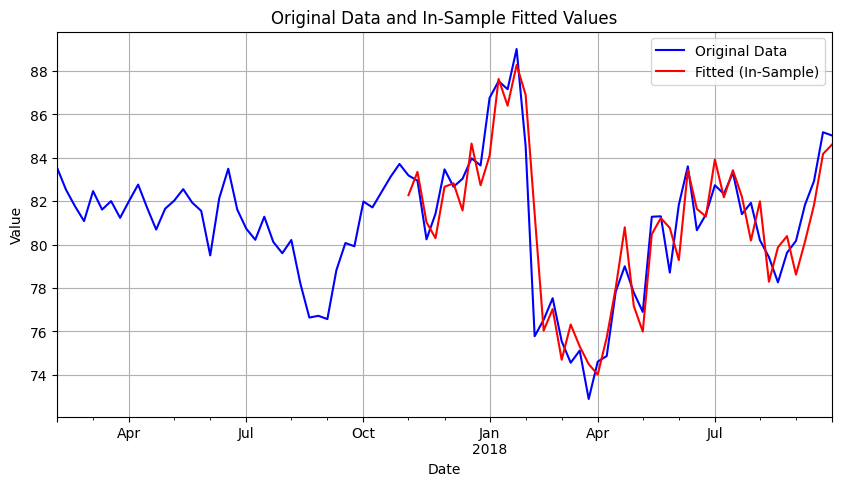

In [438]:
model = model_dict['model']
X_cols = model_dict['X_cols']
original_series = model_dict['original_series']
differenced_series = model_dict['differenced_series']
i = model_dict['i']  # differencing order
X = model_dict['X_train']
y = model_dict['y_train']

p_lags = model_dict['p']
q_lags = model_dict['q']
residuals = model_dict['residuals']

# Predict on the differenced scale (in-sample predictions)
fitted_diff = model.predict(X)

print(type(residuals))

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)
    current_value = original_series.loc[idx]

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

date
2017-11-05    0.907363
2017-11-12   -0.403940
2017-11-19   -0.787634
2017-11-26    1.127035
2017-12-03    0.802828
2017-12-10   -0.158476
2017-12-17    1.461861
2017-12-24   -0.678084
2017-12-31    0.909981
2018-01-07    2.662617
2018-01-14   -0.102396
2018-01-21    0.757060
2018-01-28    0.730673
2018-02-04   -2.362458
2018-02-11   -5.640880
2018-02-18    0.500830
2018-02-25    0.498413
2018-03-04    0.853051
2018-03-11   -1.760854
2018-03-18   -0.191058
2018-03-25   -1.605778
2018-04-01    0.595106
2018-04-08   -0.853262
2018-04-15   -0.171834
2018-04-22   -1.794305
2018-04-29    0.615529
2018-05-06    0.905841
2018-05-13    0.803822
2018-05-20    0.081872
2018-05-27   -2.054965
2018-06-03    2.547002
2018-06-10    0.169169
2018-06-17   -0.980233
2018-06-24    0.086451
2018-07-01   -1.184732
2018-07-08    0.155582
2018-07-15   -0.110252
2018-07-22   -0.800136
2018-07-29    1.733766
2018-08-05   -1.786050
2018-08-12    1.132936
2018-08-19   -1.611253
2018-08-26   -0.767042
2018-0

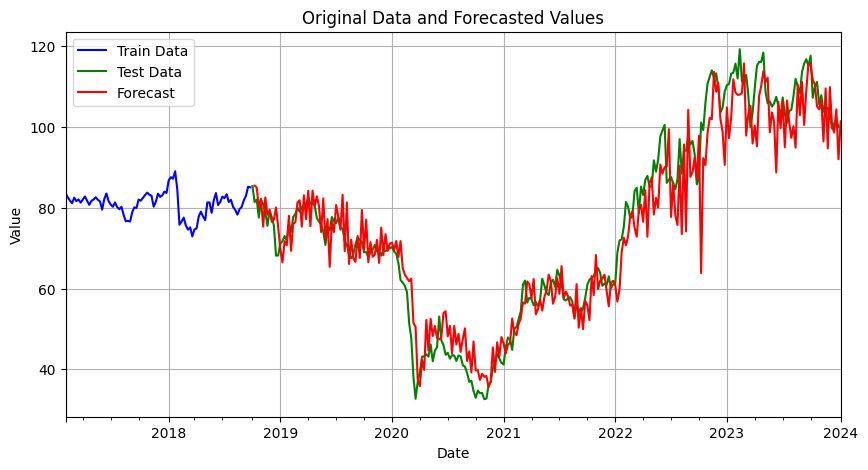

In [439]:
preds = rolling_forecast(model_dict, s)

# Get the first timestamp
start = s_test.index[1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start, periods=len(preds), freq=f)

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()



In [440]:
# Fit the ARIMA model
p = list(range(1,30))
q = list(range(1,10))

#c_model_dict = ContextualisedARIMA(p=p, i=1, q=q, s=s_train, C=C_train, n_bootstraps=30, alpha=0.1)  # ARIMA returns a model_dict

# Access and print the learned parameters
#c_coefs = c_model_dict['coefs']  # Coefficients of the AR and MA terms
#c_intercepts = c_model_dict['intercepts']  # Intercept of the linear model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/models/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 2.4 K  | train
-----------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. 

(48,)


In [467]:
from contextualized.utils import save, load

save(c_model, path='/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/contextualARIMA.pt')


In [442]:
c_model = c_model_dict['model']
c_model = load('/Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/contextualARIMA.pt')
c_X_cols = c_model_dict['X_cols']
original_series = c_model_dict['original_series']
differenced_series = c_model_dict['differenced_series']
i = c_model_dict['i']  # differencing order
X = c_model_dict['X_train']
y = c_model_dict['y_train']
C = c_model_dict['C_train']

p_lags = c_model_dict['p']
q_lags = c_model_dict['q']
residuals = c_model_dict['residuals']

print(X.tail(1))

#residuals = pd.Series(residuals, index=X.index)
print(residuals)


            lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
date                                                                        
2018-09-30   2.25   1.09   1.66   0.55   1.36  -1.16  -0.78  -1.72   0.52   

            lag_10  ...  lag_29      ma_1      ma_2      ma_3     ma_4  \
date                ...                                                  
2018-09-30   -1.91  ...   -0.99  0.850736  1.460636  2.071246  1.52275   

                ma_5      ma_6      ma_7      ma_8      ma_9  
date                                                          
2018-09-30 -0.486474 -1.740977  1.014503 -2.473981  1.856146  

[1 rows x 38 columns]
date
2017-11-05    0.473498
2017-11-12    0.048424
2017-11-19   -1.839285
2017-11-26    1.107444
2017-12-03    1.327940
2017-12-10   -0.278104
2017-12-17    0.863671
2017-12-24   -0.048331
2017-12-31    0.387039
2018-01-07    3.274298
2018-01-14   -0.251586
2018-01-21    0.355309
2018-01-28    1.405015
2018-02-04   -3.596933
2018-0

date
2017-11-05    0.473498
2017-11-12    0.048424
2017-11-19   -1.839285
2017-11-26    1.107444
2017-12-03    1.327940
2017-12-10   -0.278104
2017-12-17    0.863671
2017-12-24   -0.048331
2017-12-31    0.387039
2018-01-07    3.274298
2018-01-14   -0.251586
2018-01-21    0.355309
2018-01-28    1.405015
2018-02-04   -3.596933
2018-02-11   -7.044856
2018-02-18    0.175196
2018-02-25    0.088926
2018-03-04   -0.433319
2018-03-11   -1.298010
2018-03-18   -0.621043
2018-03-25   -1.541152
2018-04-01    0.530906
2018-04-08   -0.929279
2018-04-15    1.229893
2018-04-22   -0.493919
2018-04-29   -0.038374
2018-05-06    0.749603
2018-05-13    2.322559
2018-05-20    0.268381
2018-05-27   -1.673442
2018-06-03    2.279603
2018-06-10    1.398581
2018-06-17   -1.089092
2018-06-24    0.468595
2018-07-01   -0.019077
2018-07-08   -0.103049
2018-07-15   -0.030191
2018-07-22   -0.797341
2018-07-29    1.432451
2018-08-05   -2.503280
2018-08-12    0.803841
2018-08-19   -0.852496
2018-08-26   -0.109246
2018-0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


(48,)


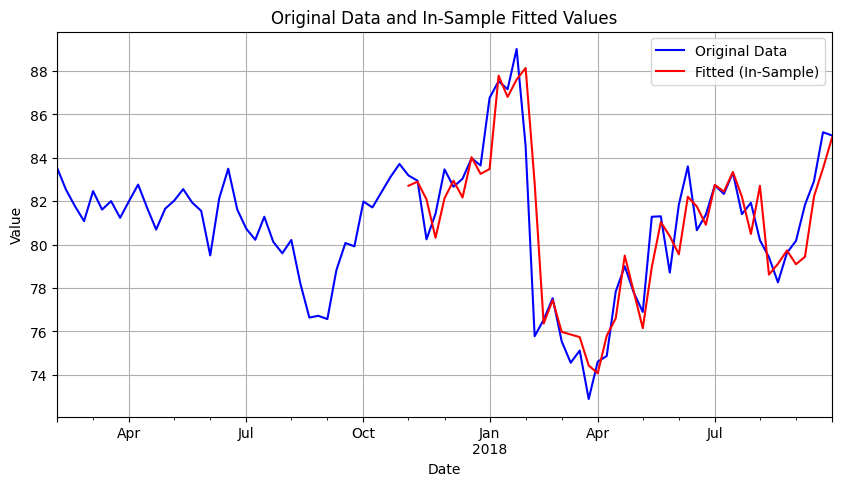

In [443]:
print(residuals)

# Predict on the differenced scale (in-sample predictions)
fitted_diff = c_model.predict(C, X.to_numpy()).flatten()
print(fitted_diff.shape)

# Invert differencing (assuming i=1)
if i > 1:
    raise NotImplementedError("Multiple differencing inversion not implemented.")

fitted_diff_series = pd.Series(fitted_diff, index=X.index, name='FittedDiff')

# To invert differencing:
# original_series[t] = original_series[t-1] + differenced_prediction[t]

# Get the initial value before the first fitted point
first_date = fitted_diff_series.index[0]
one_step_before = original_series.index.get_loc(first_date) - 1
initial_value = original_series.iloc[one_step_before]

fitted_original_values = []
current_value = initial_value
for idx in fitted_diff_series.index:
    current_value = current_value + fitted_diff_series.loc[idx]
    fitted_original_values.append(current_value)
    current_value = original_series.loc[idx]

fitted_original_series = pd.Series(fitted_original_values, index=fitted_diff_series.index, name='Fitted')

# Plot the original data and fitted values
plt.figure(figsize=(10,5))
original_series.plot(label='Original Data', color='blue')
fitted_original_series.plot(label='Fitted (In-Sample)', color='red')

plt.title("Original Data and In-Sample Fitted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [444]:
c_preds = c_rolling_forecast(c_model_dict, s, C_df)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoa

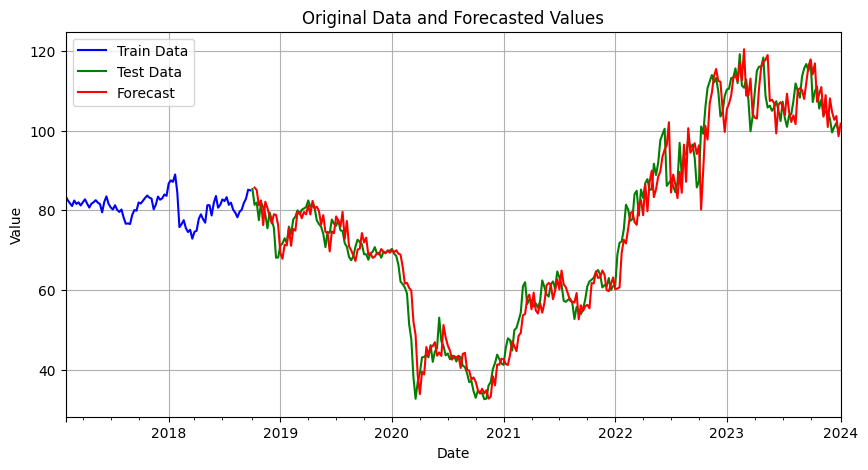

In [445]:
# Get the first timestamp
start = s_test.index[1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start, periods=len(c_preds), freq=f)

# Convert the predictions to a pandas Series
pred_series = pd.Series(c_preds, index=future_dates, name='Forecast')
mypred_series = pred_series
#print(pred_series)

# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Train Data', color='blue')
s_test.plot(ax=ax, label='Test Data', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [446]:
# Create the DataFrame
preds = preds[:len(s_test)]  # truncate preds if too long
c_preds = c_preds[:len(s_test)]  # truncate preds if too long
s_test = s_test.iloc[:len(preds)]  # truncate s_test if too long (if needed)

comparison = pd.DataFrame({
    'True': s_test.values,
    'ARIMA': preds,
    'c ARIMA': c_preds
}, index=s_test.index)

# Add 'Previous' column
comparison.insert(0, 'Previous', comparison['True'].shift(1))

# Fill the first 'Previous' with last value of training set
comparison.iloc[0, comparison.columns.get_loc('Previous')] = s_train.iloc[-1]

# Add 'True Difference' and 'Predicted Difference' columns
comparison['True Difference'] = comparison['True'] - comparison['Previous']
comparison['ARIMA Predicted Difference'] = comparison['ARIMA'] - comparison['Previous']
comparison['c ARIMA Predicted Difference'] = comparison['c ARIMA'] - comparison['Previous']

# Show it
comparison.tail(40)


,Previous,True,ARIMA,c ARIMA,True Difference,ARIMA Predicted Difference,c ARIMA Predicted Difference
date,,,,,,,
2023-04-02,103.53,109.66,95.173845,103.020152,6.13,-8.356155,-0.509848
2023-04-09,109.66,115.05,107.572452,110.780956,5.39,-2.087548,1.120956
2023-04-16,115.05,116.05,110.091993,116.024107,1.00,-4.958007,0.974107
2023-04-23,116.05,116.01,113.727021,117.229042,-0.04,-2.322979,1.179042
2023-04-30,116.01,118.34,111.053122,117.765989,2.33,-4.956878,1.755989
2023-05-07,118.34,108.68,112.165944,118.961808,-9.66,-6.174056,0.621808
2023-05-14,108.68,105.78,98.629212,107.427984,-2.90,-10.050788,-1.252016
2023-05-21,105.78,106.26,103.534113,107.764783,0.48,-2.245887,1.984783
2023-05-28,106.26,104.97,101.253054,106.879052,-1.29,-5.006946,0.619052


In [561]:
# Define a threshold for strong predicted differences
threshold = 2  # Replace t with your actual threshold value

# Filter rows where the predicted difference is greater than the threshold
mask = comparison['ARIMA Predicted Difference'] > threshold
filtered = comparison[mask]
# Compute conditional directional accuracy
conditional_directional_accuracy = 100 * (
    np.sign(filtered['True Difference']) == np.sign(filtered['ARIMA Predicted Difference'])
).mean()

# Filter rows where the predicted difference is greater than the threshold
mask = comparison['c ARIMA Predicted Difference'] > threshold
filtered = comparison[mask]
# Compute conditional directional accuracy
c_conditional_directional_accuracy = 100 * (
    np.sign(filtered['True Difference']) == np.sign(filtered['c ARIMA Predicted Difference'])
).mean()




directional_accuracy = 100 * (np.sign(comparison['True Difference']) == np.sign(comparison['ARIMA Predicted Difference'])).mean()
c_directional_accuracy = 100 * (np.sign(comparison['True Difference']) == np.sign(comparison['c ARIMA Predicted Difference'])).mean()

# MSE and MAE
mse = mean_squared_error(comparison['True'], comparison['ARIMA'])
mae = mean_absolute_error(comparison['True'], comparison['ARIMA'])
c_mse = mean_squared_error(comparison['True'], comparison['c ARIMA'])
c_mae = mean_absolute_error(comparison['True'], comparison['c ARIMA'])

print("ARIMA:")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")
print(f"Conditional Directional Accuracy (predicted > {threshold}): {conditional_directional_accuracy:.2f}%")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print('')
print("Contextualised ARIMA:")
print(f"Directional Accuracy: {c_directional_accuracy:.2f}%")
print(f"Conditional Directional Accuracy (predicted > {threshold}): {c_conditional_directional_accuracy:.2f}%")
print(f"Mean Squared Error (MSE): {c_mse:.4f}")
print(f"Mean Absolute Error (MAE): {c_mae:.4f}")

ARIMA:
Directional Accuracy: 48.18%
Conditional Directional Accuracy (predicted > 2): 52.00%
Mean Squared Error (MSE): 37.6549
Mean Absolute Error (MAE): 4.7835

Contextualised ARIMA:
Directional Accuracy: 48.18%
Conditional Directional Accuracy (predicted > 2): 59.09%
Mean Squared Error (MSE): 13.5870
Mean Absolute Error (MAE): 2.7168


In [562]:
filtered

,Previous,True,ARIMA,c ARIMA,True Difference,ARIMA Predicted Difference,c ARIMA Predicted Difference
date,,,,,,,
2019-01-27,72.99,71.72,77.966343,75.498047,-1.27,4.976343,2.508047
2019-05-19,76.56,75.91,82.278414,78.798337,-0.65,5.718414,2.238337
2019-08-04,74.81,71.75,81.259067,77.329685,-3.06,6.449067,2.519685
2020-04-05,36.95,39.21,42.327131,39.501433,2.26,5.377131,2.551433
2020-04-19,43.13,43.22,52.208331,45.713282,0.09,9.078331,2.583282
2020-05-03,43.73,43.14,52.480415,45.812503,-0.59,8.750415,2.082503
2020-05-10,43.14,46.18,48.253507,45.942335,3.04,5.113507,2.802335
2020-11-22,36.08,36.94,45.405751,38.392664,0.86,9.325751,2.312664
2021-05-30,58.92,58.37,61.879805,61.229589,-0.55,2.959805,2.309589


In [605]:
# Filter high-confidence ARIMA predictions
buys = comparison[comparison['c ARIMA Predicted Difference'] > 0]

# Create the figure
fig = go.Figure()

# Plot true values
fig.add_trace(go.Scatter(
    x=comparison.index,
    y=comparison['True'],
    name='True',
    mode='lines+markers'
))

# Add green up arrows where model predicts strongly upwards
fig.add_trace(go.Scatter(
    x=buys.index,
    y=buys['True'],
    mode='markers',
    marker=dict(color='green', size=15, symbol='triangle-up'),
    name='ARIMA Buy Signal'
))

# Update layout for clarity
fig.update_layout(
    title='High-Confidence Buy Signals',
    xaxis_title='Date',
    yaxis_title='True Value',
    height=600,
    legend=dict(x=0.01, y=0.99)
)

fig.show()


In [612]:
for t in [0,0.5, 1, 1.5, 2, 2.5]:
    # Filter high-confidence ARIMA predictions
    buys = comparison[comparison['c ARIMA Predicted Difference'] > t]
    buys['Realized Return (%)'] = buys['True Difference'] / buys['Previous'] * 100
    mean_return = buys['Realized Return (%)'].mean()
    print(t)
    print(f"Mean realized return: {mean_return:.2f}%")
    # Compute cumulative return assuming full reinvestment
    cumulative_return = (1 + buys['Realized Return (%)']/100).prod() - 1
    # Also display as %
    print(f"Cumulative return from all high-confidence buy signals: {cumulative_return * 100:.2f}%")
    hit_rate = (buys['True Difference'] > 0).mean() * 100

    print(f"Hit rate (positive return): {hit_rate:.2f}%")


0
Mean realized return: -0.20%
Cumulative return from all high-confidence buy signals: -35.17%
Hit rate (positive return): 51.49%
0.5
Mean realized return: -0.14%
Cumulative return from all high-confidence buy signals: -22.80%
Hit rate (positive return): 55.67%
1
Mean realized return: 0.21%
Cumulative return from all high-confidence buy signals: 5.39%
Hit rate (positive return): 55.22%
1.5
Mean realized return: 0.36%
Cumulative return from all high-confidence buy signals: 9.30%
Hit rate (positive return): 54.05%
2
Mean realized return: 0.92%
Cumulative return from all high-confidence buy signals: 19.25%
Hit rate (positive return): 59.09%
2.5
Mean realized return: 2.11%
Cumulative return from all high-confidence buy signals: 31.38%
Hit rate (positive return): 71.43%


,Previous,True,ARIMA,c ARIMA,True Difference,ARIMA Predicted Difference,c ARIMA Predicted Difference,Realized Return (%)
date,,,,,,,,
2018-12-02,75.49,79.50,76.487748,76.731466,4.01,0.997748,1.241466,5.311962
2018-12-16,77.64,75.58,80.037451,78.853720,-2.06,2.397451,1.213720,-2.653272
2018-12-30,68.12,68.17,69.787746,69.308675,0.05,1.667746,1.188675,0.073400
2019-01-27,72.99,71.72,77.966343,75.498047,-1.27,4.976343,2.508047,-1.739964
2019-02-24,77.71,78.42,81.269482,79.603272,0.71,3.559482,1.893272,0.913653
...,...,...,...,...,...,...,...,...
2023-08-13,107.42,111.83,110.374037,110.186493,4.41,2.954037,2.766493,4.105381
2023-09-24,116.70,114.94,115.528511,117.861704,-1.76,-1.171489,1.161704,-1.508141
2023-11-12,107.78,103.75,109.484893,108.905868,-4.03,1.704893,1.125868,-3.739098


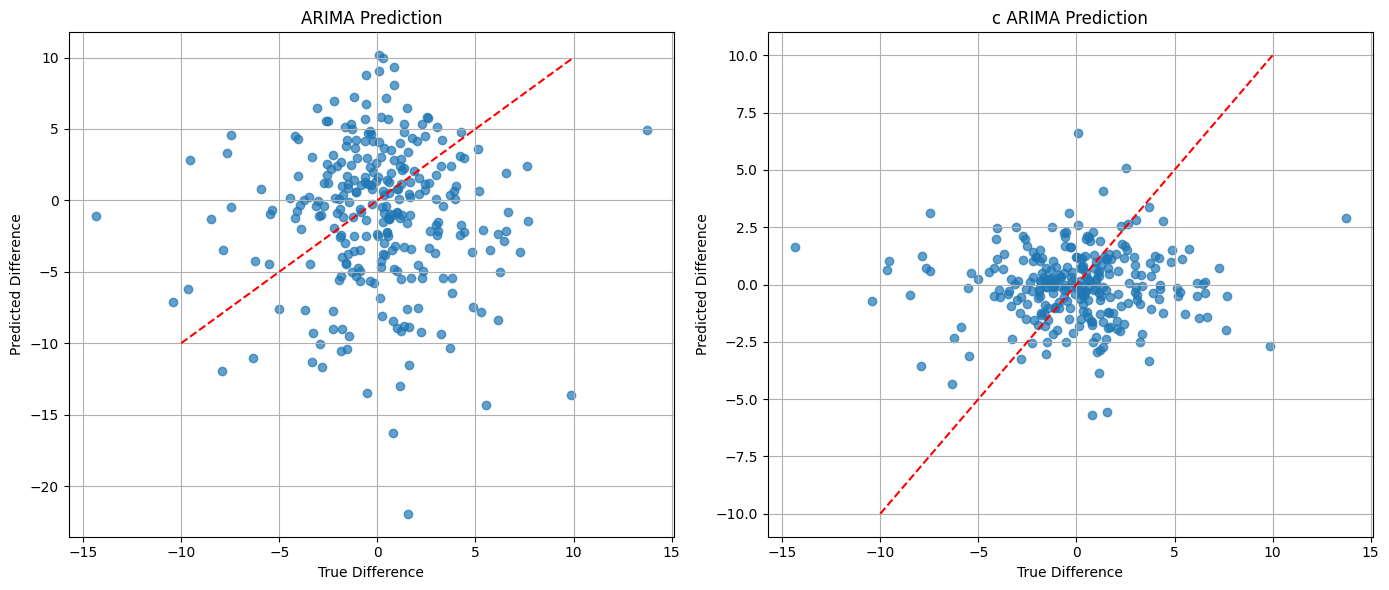

In [492]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# --- Left plot ---
axes[0].scatter(comparison['True Difference'], comparison['ARIMA Predicted Difference'], alpha=0.7)
axes[0].plot([-10, 10], [-10, 10], 'r--')  # 45-degree line
axes[0].set_title('ARIMA Prediction')
axes[0].set_xlabel('True Difference')
axes[0].set_ylabel('Predicted Difference')
axes[0].grid(True)

# --- Right plot (placeholder — duplicate or use different model if you like) ---
axes[1].scatter(comparison['True Difference'], comparison['c ARIMA Predicted Difference'], alpha=0.7)
axes[1].plot([-10, 10], [-10, 10], 'r--')
axes[1].set_title('c ARIMA Prediction')
axes[1].set_xlabel('True Difference')
axes[1].set_ylabel('Predicted Difference')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [512]:
# Assume that model_dict, df, and forecast() are already defined.
forecast_steps = 45
preds = forecast(model_dict, forecast_steps)
c_preds = c_forecast(c_model_dict, C_df, forecast_steps)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning:

The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the val

In [515]:
c_preds

[array([85.70213208]),
 array([85.47814278]),
 array([85.52890901]),
 array([85.49394358]),
 array([84.84158045]),
 array([84.11441723]),
 array([84.19208478]),
 array([84.1161311]),
 array([83.61359552]),
 array([83.96940906]),
 array([84.29766677]),
 array([84.3366183]),
 array([84.57134432]),
 array([84.81731194]),
 array([84.88291794]),
 array([84.94379809]),
 array([84.60103788]),
 array([84.26486794]),
 array([84.33740551]),
 array([84.13123074]),
 array([84.07965041]),
 array([84.45749589]),
 array([84.80262243]),
 array([84.8392315]),
 array([85.13674937]),
 array([85.3007065]),
 array([85.39078409]),
 array([85.48390533]),
 array([85.38947681]),
 array([85.26430627]),
 array([85.26994668]),
 array([85.09949043]),
 array([84.9581498]),
 array([85.07537841]),
 array([85.07200297]),
 array([85.03775555]),
 array([85.16953153]),
 array([85.27163661]),
 array([85.33003414]),
 array([85.45554575]),
 array([85.4565578]),
 array([85.44036902]),
 array([85.46631794]),
 array([85.370719

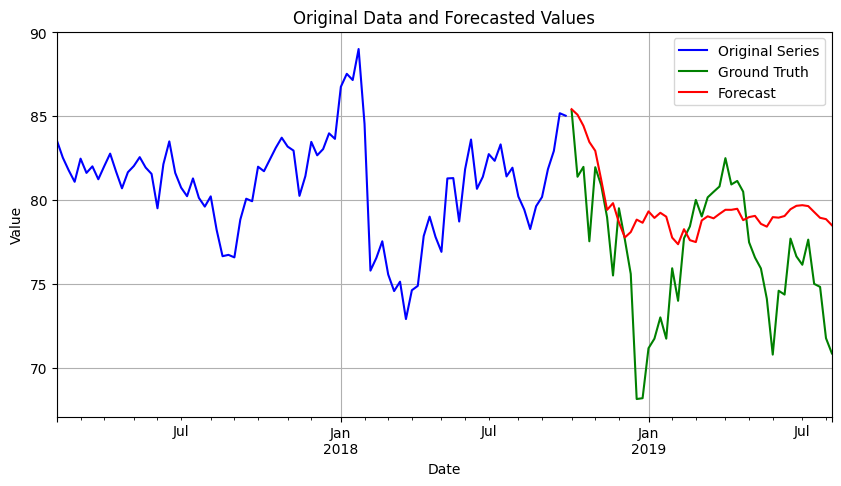

In [522]:
# Get the last timestamp from the original series
last_date = s_train.index[-1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(s_train.index[-1], periods=forecast_steps + 1, freq=f)[1:]

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')
#print(pred_series)


# Plot the original data and the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
s_train.plot(ax=ax, label='Original Series', color='blue')
s_test.iloc[:1*forecast_steps].plot(ax=ax, label='Ground Truth', color='green')
pred_series.plot(ax=ax, label='Forecast', color='red')


plt.title("Original Data and Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()